## CS584_Homework 3_Part 2

Pre-Requirement: <br>
**tensorflow**<br>
**keras**<br>
**matplotlib**

### Data Pre-processing

In [1]:
import re
import numpy as np

In [2]:
file_1 = 'a3-data/train.txt'
file_2 = 'a3-data/valid.txt'

def clean_text(filepath):
    
    f = open('a3-data/train.txt',"r", encoding='utf-8')
    lines = f.readlines()
    output = []
    for i in range(0,lines.__len__(),1):
        for word in lines[i].split():
            word = word.strip(' ')
            word = re.sub(r"[-()\"#/@;:{}'+=|.!?,]", "", word)
            output.append(word)
    
    return output

train_word = clean_text(file_1)
val_word = clean_text(file_2)

print(len(train_word))
print(train_word[0:100])
print(len(val_word))

887521
['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydroquebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snackfood', 'ssangyong', 'swapo', 'wachter', 'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov', 'N', 'mr', '<unk>', 'is', 'chairman', 'of', '<unk>', 'nv', 'the', 'dutch', 'publishing', 'group', 'rudolph', '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', 'a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it']
887521


### Build and Train the RNN Model 

In [3]:
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from pickle import dump,load
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.models import load_model

Using TensorFlow backend.


In [4]:
#convert the whole text into text sequences of four words 
train_len = 3+1
text_sequences = []
for i in range(train_len,len(train_word)):
    seq = train_word[i-train_len:i]
    text_sequences.append(seq)

sequences = {}
count = 1
for i in range(len(train_word)):
    if train_word[i] not in sequences:
        sequences[train_word[i]] = count
        count += 1

In [5]:
#we convert the data into a numpy array

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences) 

unique_words = tokenizer.index_word
unique_wordsApp = tokenizer.word_counts
vocabulary_size = len(tokenizer.word_counts)

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

In [7]:
# Splits the sequences into inputs and output labels
# One-hot embedding
train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]

train_targets = to_categorical(train_targets, num_classes=vocabulary_size+1)
seq_len = train_inputs.shape[1]
train_inputs.shape


(887517, 3)

In [8]:
# Define Model
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, seq_len, embeddings_initializer='uniform', input_length=seq_len))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(vocabulary_size,activation='softmax'))
    opt_adam = optimizers.adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy',optimizer=opt_adam,metrics=['accuracy'])
    model.summary()
    return model

In [9]:
model = create_model(vocabulary_size+1,seq_len)
path = './checkpoints/word_pred_Model4.h5'
checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='min')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 3)              29826     
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             10800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 9942)              507042    
Total params: 570,418
Trainable params: 570,418
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Training Model
history = model.fit(train_inputs,train_targets,batch_size=64,epochs=30,verbose=1,callbacks=[checkpoint])
model.save('word_pred_Model4.h5')
dump(tokenizer,open('tokenizer_Model4','wb'))    

/Users/cyp/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
887517/887517 [==============================] - 173s 195us/step - loss: 6.3414 - accuracy: 0.1075

Epoch 00001: loss improved from inf to 6.34141, saving model to ./checkpoints/word_pred_Model4.h5
Epoch 2/30
887517/887517 [==============================] - 180s 202us/step - loss: 5.8188 - accuracy: 0.1484

Epoch 00002: loss improved from 6.34141 to 5.81877, saving model to ./checkpoints/word_pred_Model4.h5
Epoch 3/30
887517/887517 [==============================] - 199s 224us/step - loss: 5.5998 - accuracy: 0.1620

Epoch 00003: loss improved from 5.81877 to 5.59980, saving model to ./checkpoints/word_pred_Model4.h5
Epoch 4/30
887517/887517 [==============================] - 190s 215us/step - loss: 5.4905 - accuracy: 0.1690

Epoch 00004: loss improved from 5.59980 to 5.49050, saving model to ./checkpoints/word_pred_Model4.h5
Epoch 5/30
887517/887517 [==============================] - 198s 223us/step - loss: 5.4234 - accuracy: 0.1734

Epoch 00005: loss improved from 5.49050 t

[567.59811404 336.55675677 270.37322764 242.37735823 226.65103514
 216.2341526  208.59687469 202.80349522 198.07991155 194.24295803
 190.98123503 188.12463478 185.72524491 183.52260941 181.69899056
 179.94543209 178.4241834  177.00980428 175.72619507 174.55102628
 173.51845796 172.55804986 171.66648331 170.77544128 169.93451296
 169.20343687 168.49655727 167.83115889 167.24920517 166.56503515]


Text(0.5, 1.0, 'Training Loss')

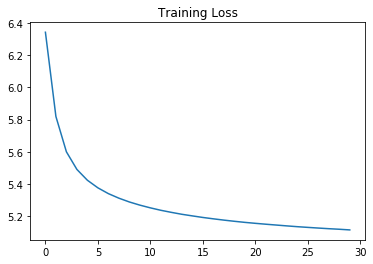

In [13]:
# Plot training loss and acc.
# Calculate the preplexity value

import matplotlib.pyplot as plt

loss = history.history['loss']
loss = np.asarray(loss)
preplexity = np.exp(loss)
print(preplexity)


plt.plot(history.history['loss'])
plt.title('Training Loss')

**Above results shows the preplexity value for each epoch.**

### Prediction

In [14]:
from keras.preprocessing.sequence import pad_sequences

In [15]:
pred_model = load_model('word_pred_Model4.h5')

/Users/cyp/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
tokenizer = load(open('tokenizer_Model4','rb'))
seq_len = 3 

In [17]:
def gen_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    output_text = []
    input_text = seed_text
    for i in range(num_gen_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len,truncating='pre')
        pred_word_ind = model.predict_classes(pad_encoded,verbose=0)[0]
        
        pred_word = tokenizer.index_word[pred_word_ind]
        input_text += ' '+pred_word
        output_text.append(pred_word)
    return ' '.join(output_text)

In [19]:
test_file = open('a3-data/input.txt',"r", encoding='utf-8')
lines = test_file.readlines()
test_line = lines[:30]
i = 1
for line in test_line:
    line = re.sub(r"[-()\"#/@;:{}'+=_|.!?,]", "", line)
    word = line.split()
    test_word = word[-1]
    out = gen_text(pred_model, tokenizer, seq_len=seq_len, seed_text=test_word, num_gen_words=1)
    print(i, "The next word of",test_word, "is :", out)
    i += 1

1 The next word of fall is : to
2 The next word of failed is : to
3 The next word of floor is : the
4 The next word of plate is : in
5 The next word of futures is : and
6 The next word of capital is : and
7 The next word of the is : <unk>
8 The next word of it is : s
9 The next word of banks is : and
10 The next word of is is : a
11 The next word of their is : <unk>
12 The next word of in is : the
13 The next word of for is : the
14 The next word of were is : <unk>
15 The next word of only is : the
16 The next word of the is : <unk>
17 The next word of extremely is : <unk>
18 The next word of placed is : by
19 The next word of big is : <unk>
20 The next word of trading is : in
21 The next word of the is : <unk>
22 The next word of after is : the
23 The next word of news is : of
24 The next word of rid is : of
25 The next word of declared is : the
26 The next word of stocks is : and
27 The next word of was is : <unk>
28 The next word of which is : <unk>
29 The next word of street is : <

We trained model many times. We found that if we reduce the training data to 10000-50000, the prediction results will be improved. The number of training data can be changed by modifying belows two line:<br>
**train_inputs = n_sequences[:,:-1][:50000]**<br>
**train_targets = n_sequences[:,-1][:50000]**<br>
We will continue to improve the model's performance:<br>
1. Adopt different methods to clean original text data.
2. Modify RNN structure.
3. Adjust Hyper-Parameters.

### Prove that perplexity is exp(total loss /number of predictions)

According to the original mathematical defintion of **Perplexity**:

$$ 2^{H(p)} = 2^{-\sum_{x} p(x)log_{2}p(x)} $$

$$ H(p) =  -\sum_{x} p(x)log_{2}p(x) $$

The above equation is entropy. More importantly, we use entropy to evaluate the similarity and calculate loss value. Therefore, we can re-write Preplexity function as:

$$perplexity = 2^{entropy}$$

$$perplexity = 2^{-\sum_{i=1}^{N}p(x_{i})log_2^{q(xi)}}$$

$$perplexity = e^{-\sum_{i=1}^{N}p(x_{i})ln^{q(xi)}}$$

$$preplexity = e^{-\sum_{i=1}^{N}\frac{1}{N}ln^{q(xi)}}$$

$$perplexity = \prod_{i=1}^{N}q(x_{i})^{-1/N} = = \sqrt[N]{\frac{1}{q(x_{1})q(x_{2})...q(x_{n})}}$$

Therefore, perplexity is exp(total loss / number of predictions)